In [91]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [92]:
model_prefix = '../models/model_lite'
input_vocab = '../data/vocab_lite.json'

embedding_dim = 100

In [93]:
class SkipGram:
    def __init__(self, vocab_size, embedding_dim, learning_rate=0.01):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.losses = []
        
        # Khởi tạo trọng số với Xavier Initialization
        limit = np.sqrt(6 / (vocab_size + embedding_dim))
        self.W1 = np.random.uniform(-limit, limit, (vocab_size, embedding_dim))  # |V| x d
        self.W2 = np.random.uniform(-limit, limit, (embedding_dim, vocab_size))  # d x |V|

    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # Stabilize computation
        return e_x / e_x.sum(axis=-1, keepdims=True)

    def forward(self, center_idx):
        """
        Forward pass to compute probabilities of context words.
        center_idx: Indices of the center words (batch_size).
        """
        center_vectors = self.W1[center_idx]  # batch_size x d
        logits = np.dot(center_vectors, self.W2)  # batch_size x |V|
        probabilities = self.softmax(logits)  # batch_size x |V|
        return probabilities, center_vectors

    def backward(self, probabilities, center_idx, context_idx):
        """
        Backward pass to compute gradients and update weights for a batch.
        probabilities: Softmax probabilities (batch_size x |V|).
        center_idx: Indices of the center words (batch_size).
        context_idx: Indices of the context words (batch_size).
        """
        batch_size = len(center_idx)
        
        # One-hot encoding for context words
        targets = np.zeros_like(probabilities)  # batch_size x |V|
        targets[np.arange(batch_size), context_idx] = 1

        # Error between predicted probabilities and target
        error = probabilities - targets  # batch_size x |V|

        # Gradients for W2 and W1
        grad_W2 = np.dot(self.W1[center_idx].T, error)  # d x |V|
        grad_W1 = np.dot(error, self.W2.T)  # batch_size x d

        # Gradient aggregation for W1 (sum gradients for same indices)
        unique_idx, inverse_idx = np.unique(center_idx, return_inverse=True)
        grouped_gradients = np.zeros((len(unique_idx), self.embedding_dim))
        np.add.at(grouped_gradients, inverse_idx, grad_W1)

        # Cập nhật W1
        self.W1[unique_idx] -= self.learning_rate * grouped_gradients
        self.W2 -= self.learning_rate * grad_W2

    def train(self, word_pairs, vocab, epochs=10, batch_size=64):
        """
        Train the Skip-gram model.
        word_pairs: List of (center_word, context_word) tuples.
        vocab: Vocabulary mapping word to index.
        """
        print("Training Skip-gram model...")
        for epoch in range(epochs):
            total_loss = 0
            np.random.shuffle(word_pairs)
            batches = [word_pairs[i:i + batch_size] for i in range(0, len(word_pairs), batch_size)]

            for batch in tqdm(batches, desc=f"Epoch {epoch+1}/{epochs}"):
                # Extract indices for batch
                center_idx = np.array([vocab[center] for center, _ in batch])
                context_idx = np.array([vocab[context] for _, context in batch])

                # Forward pass
                probabilities, _ = self.forward(center_idx)

                # Compute loss (negative log likelihood)
                batch_loss = -np.sum(np.log(probabilities[np.arange(len(context_idx)), context_idx]))
                total_loss += batch_loss

                # Backward pass
                self.backward(probabilities, center_idx, context_idx)
            
            avg_loss = total_loss / len(word_pairs)
            self.losses.append(avg_loss)
            print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")

    def get_embedding(self, word, vocab):
        """
        Retrieve the embedding vector for a given word.
        """
        return self.W1[vocab[word]]

    def cosine_similarity(self, word1, word2, vocab):
        """
        Compute cosine similarity between two words.
        """
        vec1 = self.get_embedding(word1, vocab)
        vec2 = self.get_embedding(word2, vocab)
        
        norm_vec1 = np.linalg.norm(vec1)
        norm_vec2 = np.linalg.norm(vec2)
        similarity = np.dot(vec1, vec2) / (norm_vec1 * norm_vec2)
        return similarity
    
    def save(self, path_prefix):
        np.save(f"{path_prefix}_W1.npy", self.W1)
        np.save(f"{path_prefix}_W2.npy", self.W2)
        print(f"Model saved to {path_prefix}_W1.npy and {path_prefix}_W2.npy")

    @classmethod
    def load(cls, path_prefix, vocab_size, embedding_dim, learning_rate=0.01):
        model = cls(vocab_size, embedding_dim, learning_rate)
        model.W1 = np.load(f"{path_prefix}_W1.npy")
        model.W2 = np.load(f"{path_prefix}_W2.npy")
        print(f"Model loaded from {path_prefix}_W1.npy and {path_prefix}_W2.npy")
        return model


In [94]:
with open(input_vocab, 'r') as f:
    vocab = json.load(f)

In [95]:
model = SkipGram.load(model_prefix, len(vocab), embedding_dim)
model.save(model_prefix)

Model loaded from ../models/model_lite_W1.npy and ../models/model_lite_W2.npy
Model saved to ../models/model_lite_W1.npy and ../models/model_lite_W2.npy


In [100]:
similarity = model.cosine_similarity('công_ty', 'doanh_nghiệp', vocab)
print('Similarity between "công_ty" and "doanh_nghiệp":', similarity)

similarity = model.cosine_similarity('bệnh_viện', 'y_tế', vocab)
print('Similarity between "bệnh_viện" and "y_tế":', similarity)

similarity = model.cosine_similarity('mua', 'bán', vocab)
print("Similarity between 'mua' and 'bán':", similarity)

similarity = model.cosine_similarity('tối', 'xấu', vocab)
print('Similarity between "tối" and "xấu":', similarity)

similarity = model.cosine_similarity('đại_dương', 'hạnh_phúc', vocab)
print('Similarity between "đại_dương" and "hạnh_phúc":', similarity)

similarity = model.cosine_similarity('giáo_viên', 'cửa_sổ', vocab)
print('Similarity between "giáo_viên" and "cửa_sổ":', similarity)

similarity = model.cosine_similarity('ông', 'cha', vocab)
print('Similarity between "ông" and "cha":', similarity) 

Similarity between "công_ty" and "doanh_nghiệp": 0.6762245560598559
Similarity between "bệnh_viện" and "y_tế": 0.585382316890465
Similarity between 'mua' and 'bán': 0.613483139249227
Similarity between "tối" and "xấu": 0.21036727345092737
Similarity between "đại_dương" and "hạnh_phúc": 0.11719318433262459
Similarity between "giáo_viên" and "cửa_sổ": -0.03127936671792931
Similarity between "ông" and "cha": 0.4748734326576516


In [101]:
losses = np.load('../models/model_lite_lite_W1.npy')
losses1 = np.load('../models/model_lite_lite_W2.npy')

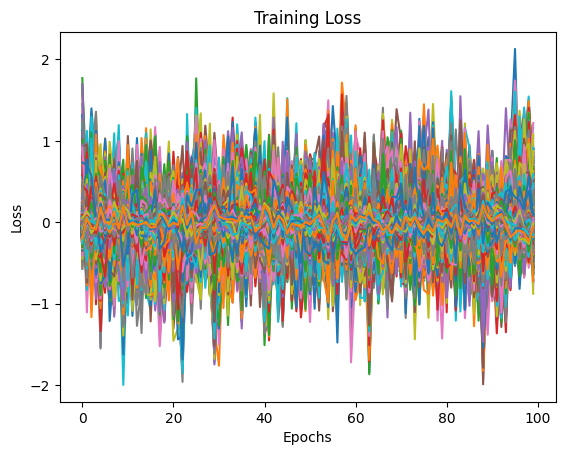

In [103]:
plt.plot(losses1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()